In [1]:
import rioxarray as rxr
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import tempfile
import os
from shapely.geometry import Point


Note that these paths may change as we tear down and recalculate burn metrics through development:

In [2]:
RBR_URL = "https://burn-severity-backend.s3.us-east-2.amazonaws.com/public/dse/York/rbr.tif"
DNBR_URL = "https://burn-severity-backend.s3.us-east-2.amazonaws.com/public/dse/York/dnbr.tif"
BOUNDARY_URL = "https://burn-severity-backend.s3.us-east-2.amazonaws.com/public/dse/York/boundary.geojson"


In [3]:
with tempfile.TemporaryDirectory() as temp_dir:
    # RBR
    RBR_PATH = os.path.join(temp_dir, "rbr.tif")
    r = requests.get(RBR_URL, allow_redirects=True)
    open(RBR_PATH, "wb").write(r.content)
    rbr = rxr.open_rasterio(RBR_PATH, masked=True).squeeze()

    # dNBR
    DNBR_PATH = os.path.join(temp_dir, "dnbr.tif")
    r = requests.get(DNBR_URL, allow_redirects=True)
    open(DNBR_PATH, "wb").write(r.content)
    dnbr = rxr.open_rasterio(DNBR_PATH, masked=True).squeeze()

    # Geojson of the fire perimeter
    BOUNDARY_PATH = os.path.join(temp_dir, "boundary.geojson")
    r = requests.get(BOUNDARY_URL, allow_redirects=True)
    open(BOUNDARY_PATH, "wb").write(r.content)
    boundary = gpd.read_file(BOUNDARY_PATH)


In [4]:
rbr

<xarray.DataArray (y: 1832, x: 1271)>
[2328472 values with dtype=float64]
Coordinates:
    band         int64 1
  * x            (x) float64 -115.3 -115.3 -115.3 ... -115.1 -115.1 -115.1
  * y            (y) float64 35.48 35.48 35.48 35.48 ... 35.13 35.13 35.13 35.13
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      stackstac-a396c2701a14f53fb07f569bb80fc46e

In [5]:
dnbr

<xarray.DataArray (y: 1832, x: 1271)>
[2328472 values with dtype=float64]
Coordinates:
    band         int64 1
  * x            (x) float64 -115.3 -115.3 -115.3 ... -115.1 -115.1 -115.1
  * y            (y) float64 35.48 35.48 35.48 35.48 ... 35.13 35.13 35.13 35.13
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      stackstac-a396c2701a14f53fb07f569bb80fc46e

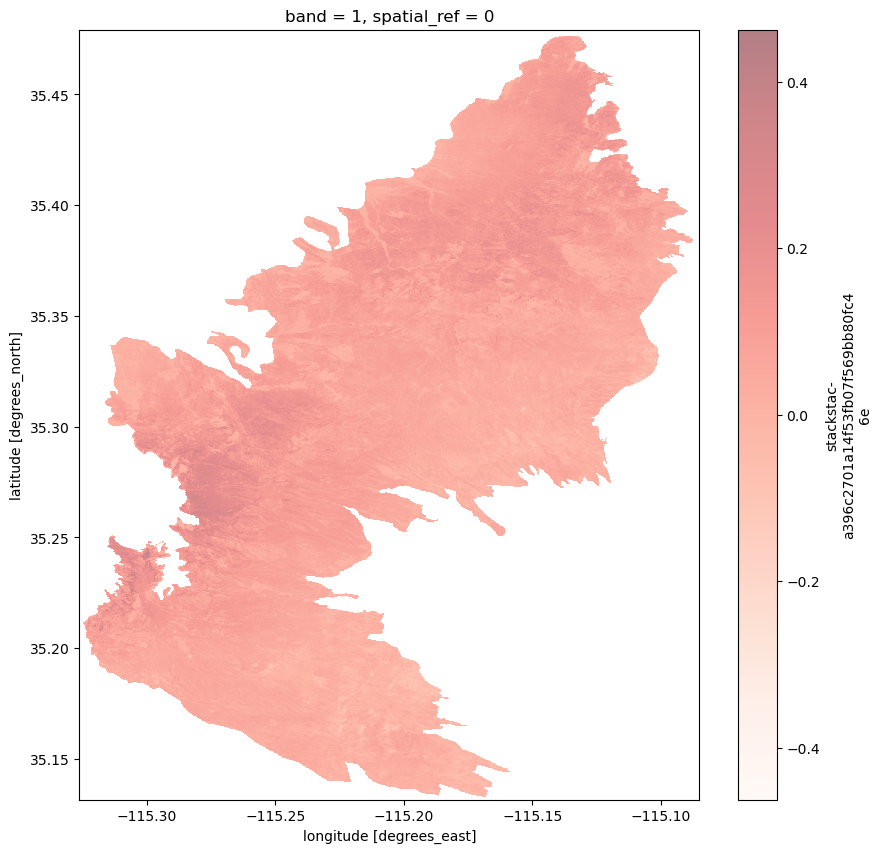

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the rbr dataArray
rbr.rio.reproject("EPSG:4326").plot.imshow(ax=ax, cmap='Reds', alpha=0.5)

plt.show()


In [11]:
df = pd.read_csv('202308_YorkSeverityObservationPoints.csv')
df['geometry'] = df.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.crs = 'EPSG:4326'
gdf

,FID,name,TimeStamp,Longitude,Latitude,SeverityFactor,geometry
0,1,High Severity,8/1/2023 0:00,-115.172180,35.296247,3,POINT (-115.17218 35.29625)
1,2,High severity,8/2/2023 0:00,-115.226196,35.302168,3,POINT (-115.22620 35.30217)
2,3,High severity/mortality YUJA woodlands,7/31/2023 0:00,-115.257442,35.316332,3,POINT (-115.25744 35.31633)
3,4,Higher burn severity,7/31/2023 0:00,-115.215690,35.253257,3,POINT (-115.21569 35.25326)
4,5,Higher severity,7/31/2023 0:00,-115.227215,35.289627,3,POINT (-115.22722 35.28963)
5,6,Moderate severity,7/31/2023 0:00,-115.192904,35.282274,2,POINT (-115.19290 35.28227)
6,7,Moderate severity,8/1/2023 0:00,-115.094502,35.369178,2,POINT (-115.09450 35.36918)
7,8,Moderate severity,8/2/2023 0:00,-115.235698,35.271425,2,POINT (-115.23570 35.27143)
8,9,Moderate severity YucSch woodlands,7/31/2023 0:00,-115.296759,35.333723,2,POINT (-115.29676 35.33372)
9,10,Moderate to high burn severity,8/1/2023 0:00,-115.122348,35.277762,2,POINT (-115.12235 35.27776)


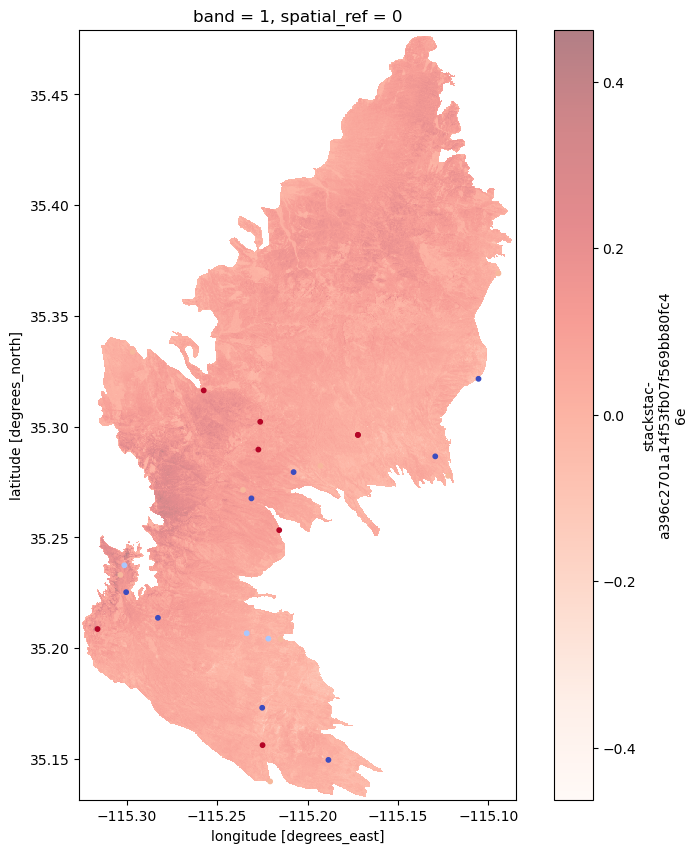

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the rbr dataArray
rbr.rio.reproject("EPSG:4326").plot.imshow(ax=ax, cmap='Reds', alpha=0.5)

# Plot the gdf points with color based on SeverityFactor
gdf.plot(ax=ax, column='SeverityFactor', cmap='coolwarm', markersize=15)

plt.show()


In [61]:
geometry = [Point(xy) for xy in zip(rbr.x.values, rbr.y.values)]
rbr_gdf = gpd.GeoDataFrame(geometry=geometry)
rbr_gdf.crs = 'EPSG:4326'

rbr_gdf.to_crs('EPSG:32610', inplace=True) # for approximate distance in meters
gdf.to_crs('EPSG:32610', inplace=True) # for approximate distance in meters


In [63]:
approx_distance = rbr_gdf.distance(gdf.geometry).mean()
approx_distance

/tmp/ipykernel_43129/1981126062.py:1: UserWarning: The indices of the two GeoSeries are different.
  distance = rbr_gdf.distance(gdf.geometry).mean()


45485.47631030453